In [22]:
from pathlib import Path

import numpy as np
import pypulseq as pp
from bmc.utils.seq.write import write_seq

import matplotlib.pyplot as plt

In [23]:
wdir = Path().resolve().parent
folder = wdir / "seq_lib"

sys = pp.Opts(
    max_grad=12000,
    grad_unit="mT/m",
    max_slew=1e9,
    slew_unit="T/m/s",
    rf_ringdown_time=0,
    rf_dead_time=0,
    rf_raster_time=1e-6,
    gamma=42576400,
    grad_raster_time=1e-6,
)
# general settings
AUTHOR = "DANIEL MIKSCH"
FLAG_PLOT_SEQUENCE = True  # plot preparation block?
FLAG_CHECK_TIMING = True  # perform a timing check at the end of the sequence?
FLAG_POST_PREP_SPOIL = True  # add spoiler after preparation block?

defs: dict = {}

### Definitions

In [29]:
seqid = "1_ETM_minus" #file name

defs["a"] = 90 # alpha in degrees
defs["b0"] = 17  # B0 [T]
defs["m0_offset"] = -10  # m0 offset [ppm]
defs["n_ETM"] = 5  # number of ETMs

#rf settings
flip_angle_90 = np.radians(defs['a'])
flip_angle_180 = np.radians(180)
t_pulse = 2e-3 

#gradient settings
spoil_amp = 0.109 * sys.max_grad  # Hz/m

crush_amp = 0.99 * sys.max_grad  # Hz/m

rise_time = 0.05e-3 #(spoil_amp / GAMMA_HZ) / sys.max_slew  # spoiler rise time in seconds
spoil_dur = 0.5e-3  # complete spoiler duration in seconds
exchange_dur = 8e-3
rephase_dur = 0.5e-3

#delay settings
delay_inter_etm = pp.make_delay(0.5e-3)
delay_exchange = pp.make_delay(8e-3)
test_delay = pp.make_delay(1e-3)

#adc
pseudo_adc = pp.make_adc(num_samples=1, duration=1e-3)


In [25]:
defs["offsets_ppm"] = np.array([defs["m0_offset"]])
defs["num_meas"] = defs["offsets_ppm"].size  # number of repetition
defs["seq_id_string"] = seqid  # unique seq id
seq_filename = defs["seq_id_string"] + ".seq"
GAMMA_HZ = sys.gamma * 1e-6
defs["freq"] = defs["b0"] * GAMMA_HZ  # Larmor frequency [Hz]

### RF events

In [26]:
rf_90 = pp.make_gauss_pulse(
    flip_angle=flip_angle_90,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

rf_90_re = pp.make_gauss_pulse(
    flip_angle=flip_angle_90,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=np.radians(180),
    return_gz=False)

rf_90_water = pp.make_gauss_pulse(
    flip_angle=np.radians(90),
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

rf_180 = pp.make_gauss_pulse(
    flip_angle=flip_angle_180,
    system=sys,
    duration=t_pulse,
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

### Gradient events

In [27]:
def create_trapezoid(amplitude, duration, rise_time, dt=sys.grad_raster_time):
    if 2 * rise_time > duration:
        raise ValueError("Die Anstiegs- und Abfallzeit zusammen dürfen nicht länger als die Gesamtdauer sein.")

    # Anzahl der Samples für jede Phase
    num_rise_samples = int(rise_time / dt)  # Anzahl der Samples für die Anstiegsphase
    num_flat_samples = int((duration - 2 * rise_time) / dt)  # Anzahl der Samples für das Plateau
    total_samples = num_rise_samples * 2 + num_flat_samples  # Gesamte Anzahl der Samples

    # Trapezoid erstellen
    trapezoid = np.zeros(total_samples)

    # Anstiegsphase: Linear von 0 bis zur Amplitude
    rise = np.linspace(0, amplitude, num_rise_samples, endpoint=False)
    trapezoid[:num_rise_samples] = rise

    # Plateau: Konstante Amplitude
    trapezoid[num_rise_samples:num_rise_samples + num_flat_samples] = amplitude

    # Abfallphase: Linear von Amplitude zurück auf 0
    fall = np.linspace(amplitude, 0, num_rise_samples, endpoint=True)
    trapezoid[num_rise_samples + num_flat_samples:] = fall

    return trapezoid

In [30]:
trapeziod_spoil = create_trapezoid(spoil_amp, spoil_dur, rise_time)
trapeziod_rephase = create_trapezoid(spoil_amp, rephase_dur, rise_time)
trapeziod_spoil_minus = create_trapezoid(-spoil_amp, spoil_dur, rise_time)
trapeziod_exchange = create_trapezoid(crush_amp, exchange_dur, rise_time)

gz_spoil = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod_spoil,
                             )

gz_rephase = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod_rephase,
                             )

gz_exchange = pp.make_arbitrary_grad(channel='z',
                                system=sys,
                                waveform=trapeziod_exchange,
                                )

gz_spoil_minus = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod_spoil_minus,
                             )

In [491]:
# dt = sys.grad_raster_time  # Zeitauflösung

# trapezoid = create_trapezoid(-spoil_amp, spoil_dur, rise_time, dt)

# # Plot
# import matplotlib.pyplot as plt
# time = np.arange(len(trapezoid)) * dt  # Zeitachse
# plt.plot(time, trapezoid)
# plt.title("Trapezoid with Slopes")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.show()
# spoil_amp

### Sequence

In [492]:
seq = pp.Sequence()
offsets_hz = defs["offsets_ppm"] * defs["freq"]  # convert from ppm to Hz

In [493]:

rf_90.freq_offset = offsets_hz[0]
rf_90_re.freq_offset = offsets_hz[0]
# rf_90.phase_offset = np.radians(-90)

for i in range(defs["n_ETM"]):
    seq.add_block(rf_90)
    seq.add_block(delay_inter_etm)
    seq.add_block(gz_spoil)
    seq.add_block(delay_inter_etm)
    seq.add_block(rf_90)
    
    seq.add_block(gz_exchange)
    # seq.add_block(delay_exchange)
    

seq.add_block(rf_90_water)
seq.add_block(gz_rephase)
seq.add_block(pseudo_adc)


Timing check passed successfully


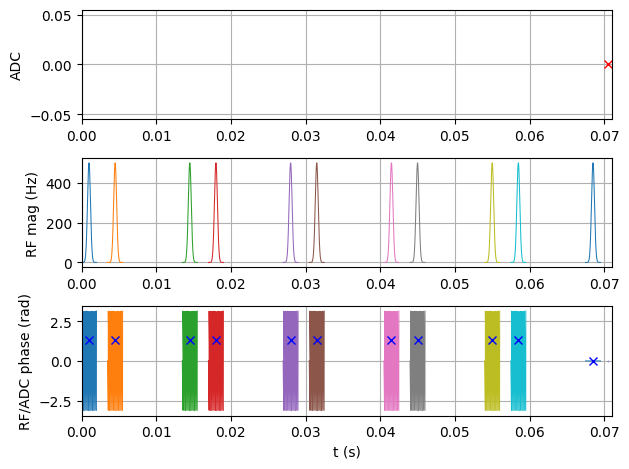

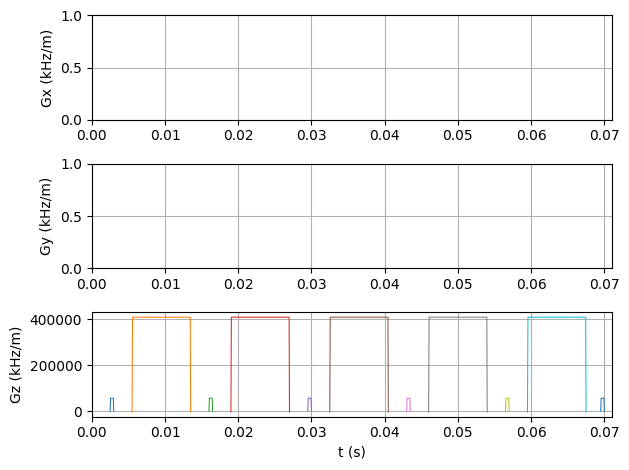

In [494]:
if FLAG_CHECK_TIMING:
    ok, error_report = seq.check_timing()
if ok:
    print("\nTiming check passed successfully")
else:
    print("\nTiming check failed! Error listing follows\n")
    print(error_report)

if FLAG_PLOT_SEQUENCE:
    seq.plot() #time_range=[0.00, .03]

In [495]:
write_seq(seq=seq, seq_defs=defs, filename=folder / seq_filename, author=AUTHOR, use_matlab_names=True)